In [1]:
# loading packages
import numpy as np
import torch
import os
import pandas as pd
from gpytorch.mlls import VariationalELBO

from scipy.stats import norm
torch.manual_seed(8927)
np.random.seed(8927)
torch.set_default_dtype(torch.float64)

import warnings
warnings.filterwarnings("ignore")

from gpytorch.mlls import VariationalELBO
from torch.utils.data import TensorDataset, DataLoader
from utilities.util import OrdinalLMC, OrdinalLikelihood
from utilities.util import correlation_matrix_distance, plot_task_kernel, evaluate_gpr


In [2]:
load_batch_size = 512
num_inducing = 1000
num_epochs = 10
model_type="both"
print("loading data...")
data = pd.read_csv("./data/loopr_data.csv", index_col=[0])
Items_loopr = data.columns.to_list()

# rename volat to violat
for i in range(1,5):
    Items_loopr[Items_loopr.index("Volat.{}".format(i))] = "Violat.{}".format(i)

# generate item map from original to current using ESM codebook
codebook = pd.read_excel("./data/ESM_Codebook.xlsx")
item_mapping = dict(zip([x.replace(" ", "") for x in codebook.iloc[:,0].to_list()],\
                        [x.replace(" ", "") for x in codebook.iloc[:,1].to_list()]))
reverse_code = codebook.iloc[:,2].to_list()
item_description = codebook.iloc[:,3].to_list()

data = pd.read_csv("./data/GP_ESM_cleaned.csv")
data.columns = [x.replace(" ", "") for x in data.columns]
ESM_items = [x.replace(" ", "") for x in codebook.iloc[:,0].to_list() if x.replace(" ", "") in Items_loopr]
reverse_code = [reverse_code[i] for i in range(codebook.shape[0]) if codebook.iloc[i,0].replace(" ", "") in Items_loopr]
reverse_code = np.array(reverse_code).reshape(-1,1)
time_diff = (pd.to_datetime(data.RecordedDate, format='%Y-%m-%d %H:%M:%S')-pd.to_datetime(data.RecordedDate[0])).dt
data["day"] = time_diff.days
data["day"] += time_diff.seconds/60/60/25

n = data.PID.unique().shape[0]
m = len(ESM_items)
horizon = data.day.max()

train_x = torch.zeros((n*m*data.n.max(),3))
train_y = torch.zeros((n*m*data.n.max(),))

ITER = 0
for iter in range(data.shape[0]):
    for j in range(m):
        train_x[ITER, 0] = data.PID[iter]
        train_x[ITER, 1] = j
        train_x[ITER, 2] = data.day[iter]
        train_y[ITER] = data[item_mapping[ESM_items[j]]][iter]
        ITER += 1

train_x = train_x[~train_y.isnan()]
train_y = train_y[~train_y.isnan()]
train_x = train_x[train_y!=0]
train_y = train_y[train_y!=0]

loading data...


In [4]:
train_y.shape

torch.Size([263100])

In [114]:
i=1
pop_kernel = torch.tensor(pop_prior["pop_factor"])
pop_kernel =  model.pop_task_covar_module.covar_matrix.evaluate()
unit_cov =  torch.tensor(pop_prior["unit_{}_covariance".format(i)])
unit_cov = pop_kernel - unit_cov
U, S, V = torch.pca_lowrank(unit_cov.double(), q = 1)
X_init = tmp = U.matmul(S).reshape((-1,1)) @ V.T
model.unit_task_covar_module[i].covar_factor.data = X_init
model.unit_task_covar_module[i].raw_var.data = torch.tensor([-10.])
unit_cov2 = model.unit_task_covar_module[i].covar_matrix.evaluate()

print(torch.norm(unit_cov-unit_cov2))

tensor(5.9670, grad_fn=<CopyBackwards>)


In [128]:
idx=0
test_mask = (idx*9<=train_x[:,1])
test_mask = test_mask & (train_x[:,1]<(idx*9+9))
print(test_mask.numpy().sum())
# test_mask = torch.bernoulli(test_mask*0.5)
print(torch.bernoulli(test_mask*0.5).numpy().sum())

52620
26299.0


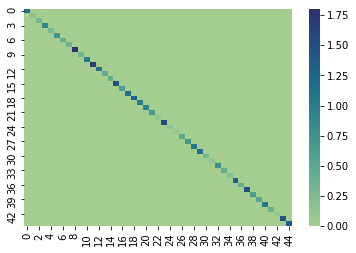

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.close()
plt.figure()
sns.heatmap(unit_cov.data.numpy(), cmap="crest")
plt.show()

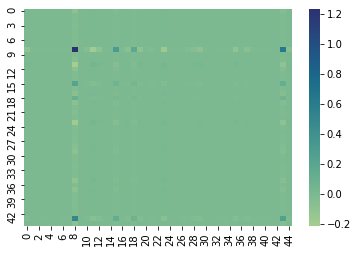

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.close()
plt.figure()
tmp = U.matmul(S).reshape((-1,1)) @ V.T
sns.heatmap(tmp.detach().numpy(), cmap="crest")
plt.show()

In [40]:
pop_prior = np.load("./results/GP_ESM/both_f1_Feb.npz")
print(pop_prior.files)

['train_acc', 'train_ll', 'log_lik', 'BIC', 'pop_covariance', 'pop_factor', 'unit_0_covariance', 'unit_1_covariance', 'unit_2_covariance', 'unit_3_covariance', 'unit_4_covariance', 'unit_5_covariance', 'unit_6_covariance', 'unit_7_covariance', 'unit_8_covariance', 'unit_9_covariance', 'unit_10_covariance', 'unit_11_covariance', 'unit_12_covariance', 'unit_13_covariance', 'unit_14_covariance', 'unit_15_covariance', 'unit_16_covariance', 'unit_17_covariance', 'unit_18_covariance', 'unit_19_covariance', 'unit_20_covariance', 'unit_21_covariance', 'unit_22_covariance', 'unit_23_covariance', 'unit_24_covariance', 'unit_25_covariance', 'unit_26_covariance', 'unit_27_covariance', 'unit_28_covariance', 'unit_29_covariance', 'unit_30_covariance', 'unit_31_covariance', 'unit_32_covariance', 'unit_33_covariance', 'unit_34_covariance', 'unit_35_covariance', 'unit_36_covariance', 'unit_37_covariance', 'unit_38_covariance', 'unit_39_covariance', 'unit_40_covariance', 'unit_41_covariance', 'unit_42_c

In [33]:
idx = 4
test_mask = (idx*9<=train_x[:,1])
test_mask = test_mask & (train_x[:,1]<(idx*9+9))
print(train_x[~test_mask].shape)

torch.Size([157860, 3])


In [43]:
C = 5
Q = 5
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=load_batch_size, shuffle=True)

# initialize likelihood and model
inducing_points = train_x[np.random.choice(train_x.size(0),num_inducing,replace=False),:]
likelihood = OrdinalLikelihood(thresholds=torch.tensor([-20.,-2.,-1.,1.,2.,20.]))
model = OrdinalLMC(inducing_points,n=n,m=m,C=C,horizon=horizon,\
                   pop_rank=Q, unit_rank=1, model_type=model_type)

model.train()
likelihood.train()

# initialize covariance of pop factors
pop_prior = np.load("./results/GP_ESM/both_f1_Feb.npz")
loopr_idx = [Items_loopr.index(x) for x in ESM_items]
model.pop_task_covar_module.covar_factor.data = torch.tensor(pop_prior["pop_factor"])
# reverse_code

In [172]:
# select hyperparameters to learn
for i in range(n):
    model.t_covar_module[i].lengthscale = data.day.max() // 3 
model.fixed_module.raw_lengthscale.requires_grad = False

final_params = list(set(model.parameters()) - \
                    {model.fixed_module.raw_lengthscale}) + \
                list(likelihood.parameters())

num_params = 0
for p in final_params:
    if p.requires_grad:
        num_param = np.prod(p.size())
        if num_param<num_inducing:
            num_params += num_param
print("num of model parameters: {}".format(num_params))

optimizer = torch.optim.Adam(final_params, lr=0.1)

# Our loss object. We're using the VariationalELBO
mll = VariationalELBO(likelihood, model, num_data=train_y.size(0))

# train GPR
print("start training...")
for i in range(num_epochs):
    log_lik = 0
    for j, (x_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        loss.backward()
        optimizer.step()
        log_lik += -loss.item()*y_batch.shape[0]
        if j % 50:
            print('Epoch %d Iter %d - Loss: %.3f' % (i + 1, j+1, loss.item()))
    print('Epoch %d - log lik: %.3f' % (i + 1, log_lik))

num of model parameters: 549.0
start training...
Epoch 1 Iter 2 - Loss: 3.572
Epoch 1 Iter 3 - Loss: 3.431
Epoch 1 Iter 4 - Loss: 3.293
Epoch 1 Iter 5 - Loss: 3.117
Epoch 1 Iter 6 - Loss: 3.067
Epoch 1 Iter 7 - Loss: 3.015
Epoch 1 Iter 8 - Loss: 2.992
Epoch 1 Iter 9 - Loss: 2.926
Epoch 1 Iter 10 - Loss: 2.901
Epoch 1 Iter 11 - Loss: 2.852
Epoch 1 Iter 12 - Loss: 2.847
Epoch 1 Iter 13 - Loss: 2.802
Epoch 1 Iter 14 - Loss: 2.757
Epoch 1 Iter 15 - Loss: 2.737
Epoch 1 Iter 16 - Loss: 2.862
Epoch 1 - log lik: -23618.695
Epoch 2 Iter 2 - Loss: 2.734
Epoch 2 Iter 3 - Loss: 2.720
Epoch 2 Iter 4 - Loss: 2.748
Epoch 2 Iter 5 - Loss: 2.691
Epoch 2 Iter 6 - Loss: 2.710
Epoch 2 Iter 7 - Loss: 2.726
Epoch 2 Iter 8 - Loss: 2.758
Epoch 2 Iter 9 - Loss: 2.716
Epoch 2 Iter 10 - Loss: 2.790
Epoch 2 Iter 11 - Loss: 2.695
Epoch 2 Iter 12 - Loss: 2.795
Epoch 2 Iter 13 - Loss: 2.719
Epoch 2 Iter 14 - Loss: 2.702
Epoch 2 Iter 15 - Loss: 2.662
Epoch 2 Iter 16 - Loss: 2.583
Epoch 2 - log lik: -21012.895
Epoch 3

In [185]:
# prediction
model.eval()
likelihood.eval()

train_acc, train_ll = evaluate_gpr(model, likelihood, train_loader)

results = {}
print("in-sample evaluatiion...")
print("train acc: {}".format(train_acc))
print("train ll: {}".format(train_ll))

results["train_acc"] = train_acc
results["train_ll"] = train_ll
results["log_lik"] = log_lik
results["BIC"] = num_params*np.log(train_x.size(0)) - 2*log_lik 

task_kernel = model.pop_task_covar_module.covar_matrix.evaluate().detach().numpy()
results["pop_covariance"] = task_kernel
results["pop_factor"] = model.pop_task_covar_module.covar_factor.data.detach().numpy()

unit_covariance = np.zeros((n,m,m))
for i in range(n):
    task_kernel = np.zeros((m,m))
    task_kernel += model.pop_task_covar_module.covar_matrix.evaluate().detach().numpy()
    task_kernel += model.unit_task_covar_module[i].covar_matrix.evaluate().detach().numpy()
    unit_covariance[i] = task_kernel
    results["unit_{}_covariance".format(i)] = task_kernel

PATH = "./results/GP_ESM/"
if not os.path.exists(PATH):
    os.makedirs(PATH)
np.savez(PATH+"pop_5.npz", **results)

item_order = sorted(range(len(ESM_items)), key=lambda k: ESM_items[k])
plot_task_kernel(task_kernel[item_order,:][:,item_order], np.array(ESM_items)[item_order], "./results/GP_ESM/pop_5.pdf", SORT=False)


in-sample evaluatiion...
train acc: 0.36186770428015563
train ll: -1.38479083313877
out-of-sample evaluatiion...
